In [21]:
import warnings
import graphviz
import re
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.tools.eval_measures import rmse
from statsmodels.stats.outliers_influence import variance_inflation_factor # 다중공선성 패키지 불러오기
from sklearn.linear_model import LinearRegression # sklearn 선형회귀 모형 -> 변수 선택법을 위함
from sklearn.feature_selection import RFE # 변수 선택법 (후진 제거법)
from sklearn.preprocessing import scale # 데이터 scale
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score, fbeta_score
# Import ML Classification algos
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.cross_validation import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
warnings.filterwarnings('ignore')
%matplotlib inline
matplotlib.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus']=False
data = pd.read_csv("./유방암.CSV",engine="python")
data.head()

ModuleNotFoundError: No module named 'sklearn.cross_validation'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
diagnosis                  569 non-null int64
mean radius                569 non-null float64
mean texture               569 non-null float64
mean perimeter             569 non-null float64
mean area                  569 non-null float64
mean smoothness            569 non-null float64
mean compactness           569 non-null float64
mean concavity             569 non-null float64
mean concave points        569 non-null float64
mean symmetry              569 non-null float64
mean fractal dimension     569 non-null float64
radius error               569 non-null float64
texture error              569 non-null float64
perimeter error            569 non-null float64
area error                 569 non-null float64
smoothness error           569 non-null float64
compactness error          569 non-null float64
concavity error            569 non-null float64
concave points error       569 no

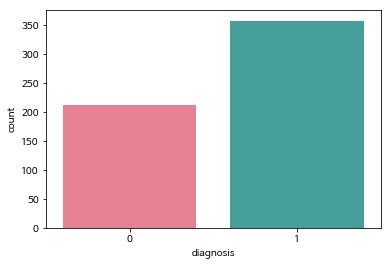

In [4]:
# 결측치 없다.
data.isnull().sum(axis=0)
#데이터 타입 확인
data.info()
# Checking if classes are unbalanced or balanced
data['diagnosis'].value_counts()
# '1' 은 Malignant으로 악성이다 -> 212/(212 + 357) = 0.37 
# '0' 은 Benign으로 양성이다 -> 357/(212+357) = 0.627
sns.countplot(data.diagnosis)
sns.countplot(data['diagnosis'],  palette = "husl")

# 데이터 스케일
- **1. 모든 분포가 왼쪽으로 치우쳐 있기 때문에 로그 변환을 적용해 분포를 보다 정상으로 만들고 왼쪽 꼬리를 중앙으로 sacle한다**

- **2. 전체 데이터를 (0,1)사이의 MinMaxScaler과 평균 0 표준 편차 1 만들어 값을 변화시킨다.**

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002AE2947AE10>,
      dtype=object)

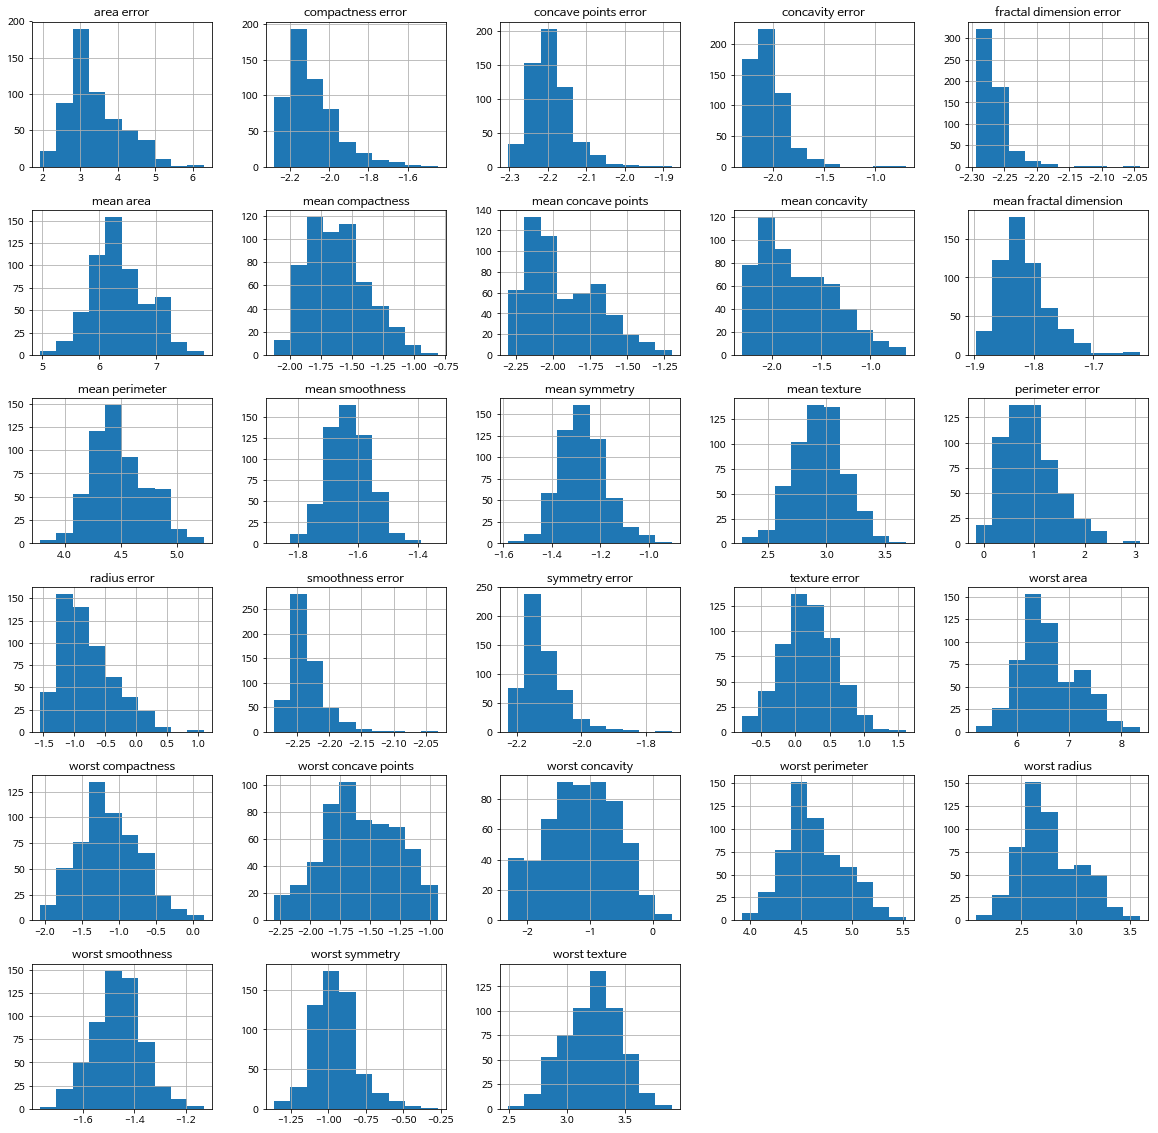

In [5]:
y = data.loc[:,'diagnosis']
X = data.iloc[:,2:-1]

X_log = X.apply(lambda x: np.log(x + 0.1))

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_log)
X_log.hist(figsize = (20,20))

# 데이터 분할 (train, test 데이터 7:3)
- Data set을 train과 test로 나누고 초기화한다

In [7]:
# 데이터 분할(train, test 데이터 7:3으로 - numpy->random)
np.random.seed(seed=1234)

# 0.7보다 작으면 True -> train 데이터, 아니면 False -> test 데이터
msk = np.random.rand(data.shape[0]) < 0.7
data_train = data[msk]
data_test = data[~msk]

# train/test 데이터의 목표변수/설명변수 지정
data_train_y = data_train["diagnosis"]
data_train_x = data_train.drop("diagnosis", axis=1, inplace=False)
data_test_y = data_test["diagnosis"]
data_test_x = data_test.drop("diagnosis", axis=1, inplace=False)

# train데이터와 test데이터 크기
print("train data X size: {}".format(data_train_x.shape))
print("train data Y size: {}".format(data_train_y.shape))
print("test data X size: {}".format(data_test_x.shape))
print("test data Y size: {}".format(data_test_y.shape))

# train data: 385, test data: 184

train data X size: (385, 30)
train data Y size: (385,)
test data X size: (184, 30)
test data Y size: (184,)


# SVC 정확도 비교
- Accuracy on training set:1.0
- Accuracy on training set:0.65

In [8]:
rf_uncustomized = SVC(random_state=1234)
rf_uncustomized.fit(data_train_x, data_train_y)

# 훈련 데이터 정확도
print("Accuracy on training set:{:.3f}".format(rf_uncustomized.score(data_train_x,
                                                                      data_train_y)))
print("Accuracy on training set:{:3f}".format(rf_uncustomized.score(data_test_x,
                                                                      data_test_y)))

Accuracy on training set:1.000
Accuracy on training set:0.652174


# tree model 옵션 확인

In [10]:
rf_uncustomized.get_params

<bound method BaseEstimator.get_params of SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=1234,
  shrinking=True, tol=0.001, verbose=False)>

# GridSearchCV 사용
- **CRiterion: 분리 기준 변경(gini, entropy)**
- **depth는 1~50까지 잡는다. (tree - 최대 깊이)**
- **num_leafs는 Tree의 leaf**
- **GridSearchCV.fit 저장**

In [18]:
svm_uncustomized = SVC(random_state=1234)
svm_uncustomized.fit(data_train_x, data_train_y)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=1234,
  shrinking=True, tol=0.001, verbose=False)

# SVM Model 생성
- **accuracy와 recall을 점수 측정 지표로 사용**
- **두 model 둘다 최적 model과 동일한 모델을 사용한다**

In [33]:
svc=SVC()
param_grid = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4, 1e-5],'C': [1, 10, 100, 1000]},
              {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]
scores = ['accuracy', 'recall']
for sc in scores:
    grid=GridSearchCV(svc,param_grid,cv=10,scoring=sc,n_jobs=-1)
    print("# Tuning hyper-parameters for %s" % sc)
    grid.fit(data_train_x,data_train_y)
    print(grid.best_params_)
    print(np.round(grid.best_score_,3))

# Tuning hyper-parameters for accuracy
{'C': 10, 'kernel': 'linear'}
0.956
# Tuning hyper-parameters for recall
{'C': 10, 'gamma': 1e-05, 'kernel': 'rbf'}
0.975


# GridSearch 출력
- **GridSearch를 했을 때 가장좋은 test accuracy중 가장 좋은 score를 출력**
- **그 때 조합들의 parameter를 출력했다.**

In [34]:
print(grid.best_score_)
print(grid.best_params_)

0.9745765104460755
{'C': 10, 'gamma': 1e-05, 'kernel': 'rbf'}


In [35]:
my_model = grid.best_estimator_
my_model.fit(data_train_x,data_train_y)

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=1e-05, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [36]:
# 최종 모델
rf_model = SVC(C=10,gamma=1e-5,kernel='rbf',random_state=1234)
rf_model.fit(data_train_x,data_train_y)
# rf_model.featrue_importance_로 설명변수 중요도 확인
ds_feature_importance = pd.DataFrame()
ds_feature_importance["feature"] = data_train_x.columns
ds_feature_importance["importance"] = rf_model.feature_importances_
ds_feature_importance.sort_values(by="importance",ascending=False)


AttributeError: 'SVC' object has no attribute 'feature_importances_'